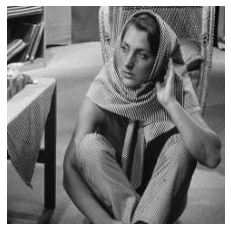

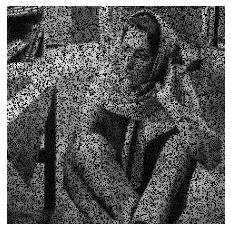

loss_fid:0.16,nmae_test:0.43, loss_all:0.16. Trainning progress: 0.0 %:  

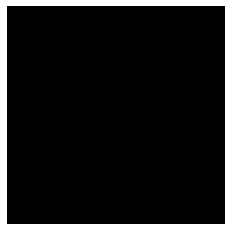

RMSE: 0.4783371
loss_fid:0.011,nmae_test:0.11, loss_all:0.015. Trainning progress: 50.0 %:  ▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋

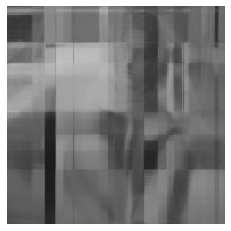

RMSE: 0.1292399
loss_fid:0.00048,nmae_test:0.047, loss_all:0.0012. Trainning progress: 1e+02 %:  ▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋

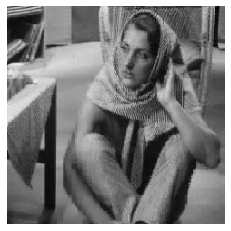

RMSE: 0.045978792
loss_fid:0.16,nmae_test:0.43, loss_all:0.16. Trainning progress: 0.0 %:  

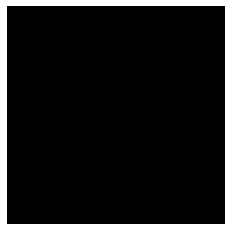

RMSE: 0.4783359
loss_fid:0.00064,nmae_test:0.074, loss_all:0.00064. Trainning progress: 50.0 %:  ▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋

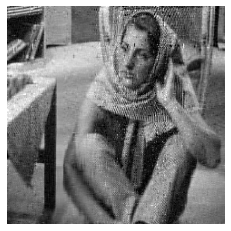

RMSE: 0.06601506
loss_fid:1.4e-05,nmae_test:0.13, loss_all:1.4e-05. Trainning progress: 1e+02 %:  ▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋

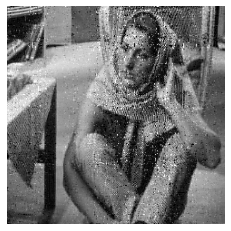

RMSE: 0.11189508


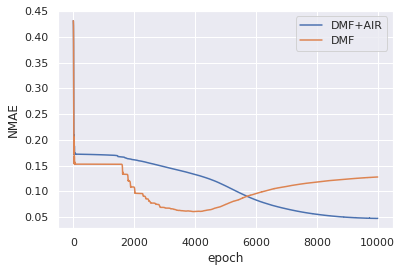

In [3]:
# Image type matrix completion
# Loss fixed pionts
from MinPy import demo,net,reg
import torch as t
from MinPy.toolbox import dataloader,plot,pprint,io
import numpy as np
np.random.seed(20210909)
m,n,epoch = 240,240,10001 #Height, width and training times of the image
miss_mode = 'random' #Can be 'random', 'fixed' and 'patch'
pic = dataloader.get_data(height=n,width=n,pic_name='./train_pics/Barbara.jpg').cuda() #Read grayscale image
plot.gray_im(pic.cpu()) #Display grayscale image
transformer = dataloader.data_transform(z=pic,return_type='tensor')
if miss_mode == 'random':
    mask_in = transformer.get_drop_mask(rate=0.3) #'rate' is the loss rate
    mask_in[mask_in<1] = 0
elif miss_mode == 'patch':
    mask_in = t.ones((m,n)).cuda()
    mask_in[70:100,150:190] = 0
    mask_in[200:230,200:230] = 0
elif miss_mode == 'fixed':
    mask_in = dataloader.get_data(height=n,width=n,pic_name='./masks/mask.png')
    mask_in[mask_in<1] = 0
else:
    raise('Wrong miss_mode: '+miss_mode)
plot.gray_im(pic.cpu()*mask_in.cpu())


line_dict={}
for reg_mode in ['DMF+AIR','DMF']:
    reg_hc = reg.hc_reg(name='lap')
    reg_row = reg.auto_reg(m,'row')
    reg_col = reg.auto_reg(n,'col')
    reg_cnn = reg.cnn_reg()
    dmf = demo.basic_dmf([m,m,m,n],[reg_hc,reg_row,reg_col,reg_cnn]) #Define model

    #Training model
    for ite in range(epoch):
        if reg_mode == 'DMF':
            eta = [None,None,None,None]
        else:
            eta = [None,1e-4,1e-4,None]
        #eta = [1e-3,None,None,None]
        dmf.train(pic,mu=1,eta=eta,mask_in=mask_in)
        if ite % 100==0:
            pprint.progress_bar(ite,epoch,dmf.loss_dict) # Format the loss of the output training and print out the training progress bar
        if ite % 5000==0:
            plot.gray_im(dmf.net.data.cpu().detach().numpy()) # Display the training image, you can set parameters to save the image
            print('RMSE:',t.sqrt(t.mean((pic-dmf.net.data)**2)).detach().cpu().numpy())
            #plot.gray_im(dmf.net.show_img().cpu().detach().numpy()) # Display the training image, you can set parameters to save the image

    # plot
    line_dict['x_plot']=np.arange(0,epoch,1)
    dmf.loss_dict['loss_auto_reg_col'] = []
    dmf.loss_dict['loss_auto_reg_row'] = []
    dmf.loss_dict['loss_fid'] = []
    dmf.loss_dict['loss_all'] = []
    for key in dmf.loss_dict.keys():
        if dmf.loss_dict[key] != []:
            line_dict[reg_mode] = np.array(dmf.loss_dict[key])


plot.lines(line_dict,save_if=False,black_if=True,ylabel_name='NMAE')
    


